# Getting started with measurement uncertainty

Imagine four groups of students measuring the same product, each group measures 25 samples and we need to obtain our decision about the mean value of the product measured. For instance, a machine shop generated cylinders and we need to see what is the mean diameter and how it varies if at all, among different machines, days or hours of manufacturing. 

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
np.random.seed(42)  # For reproducibility

# Simulate data
# (a) Accurate & Precise
data_a = np.random.normal(loc=10, scale=0.3, size=25)
# (b) Accurate, Not Precise
data_b = np.random.normal(loc=10, scale=1.0, size=25)
# (c) Precise, Not Accurate
data_c = np.random.normal(loc=7, scale=0.3, size=25)
# (d) Neither Accurate nor Precise
data_d = np.random.normal(loc=7, scale=1.0, size=25)


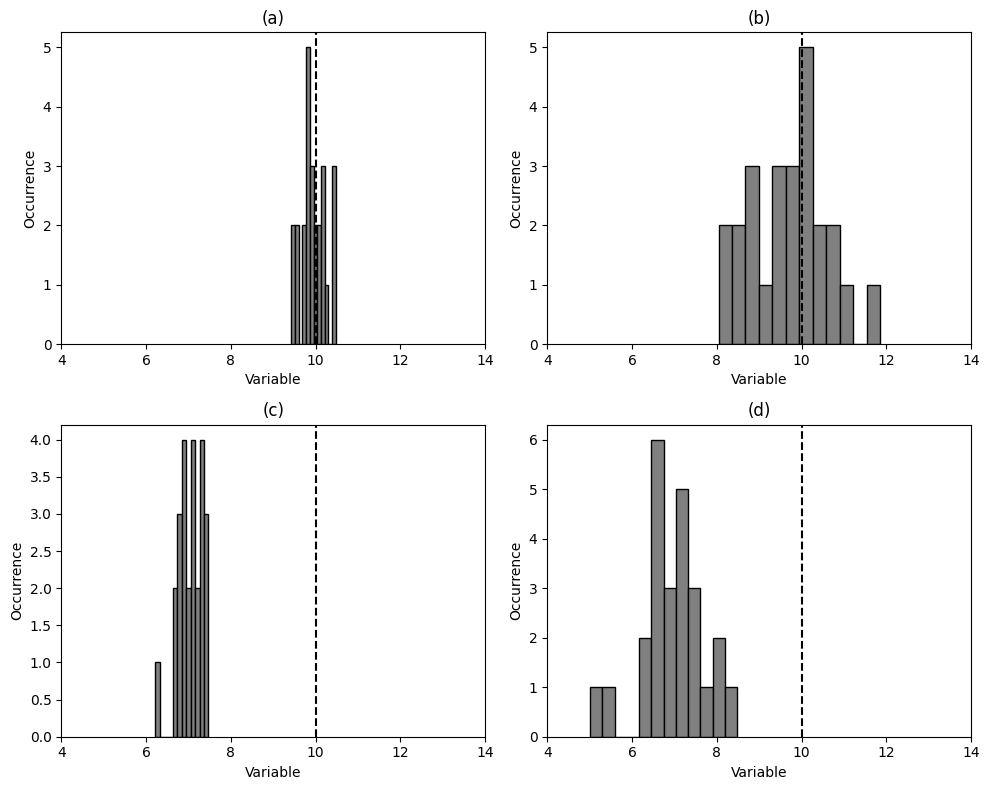

In [16]:

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
groups = [data_a, data_b, data_c, data_d]
titles = ['(a)', '(b)', '(c)', '(d)']

for i, (group, ax, title) in enumerate(zip(groups, axs.ravel(), titles)):
    ax.hist(group, bins=12, color='gray', edgecolor='black')
    ax.set_xlabel('Variable')
    ax.set_ylabel('Occurrence')
    ax.set_title(title)
    ax.axvline(10, color='k', linestyle='--')  # True value at 10
    ax.set_xlim([4, 14])

plt.tight_layout()
plt.show()

## Discussion in the class:
1. How is it possible that the four groups measured things so different? 
2. Why would we believe or think that when we get into the lab, things go better? 
3. What does it mean for the uncertainty? What is uncertainty? 


### 1. **Measuring Three Dimensions of Multiple Objects (e.g., Rivets)**

We'll simulate measuring the *length*, *shaft diameter*, and *head diameter* of 100 'objects', with random variations to represent human and instrument error.

### 2. **Calculation of Mean and (Precision) Uncertainty**

We'll script calculation of the mean and standard deviation as uncertainty for both large (>30) and small ($<30$) sample sizes. For small samples, Student's t-distribution will be used as in the paper.

### 3. **Propagation of Uncertainties**

We'll demonstrate uncertainty propagation in a derived calculation (e.g., cylinder volume from measured length and diameter), using both partial derivatives and combining uncertainties in quadrature.

### 4. **Comparison: Measuring a Whole vs. Measuring Parts**

We'll simulate measuring four segments individually versus measuring the total as a whole, then compare the propagated uncertainty with the direct measurement uncertainty.

***

Below, you’ll find standalone Python code for each part. You can use these sequentially in a Jupyter Notebook, or as separate Python scripts.


## 3.1. Simulate Measurement of Three Dimensions


In [19]:
import numpy as np
import pandas as pd

np.random.seed(0)
n = 100  # number of objects

# True values
true_length = 0.980      # inches
true_shaft = 0.310       # inches
true_head = 0.541        # inches

# Simulate measurements with instrument/human error (normal distribution around true value)
lengths = np.random.normal(true_length, 0.020, n)
shafts = np.random.normal(true_shaft, 0.007, n)
heads = np.random.normal(true_head, 0.014, n)

data = pd.DataFrame({
    'Length (in)': lengths,
    'Shaft Diameter (in)': shafts,
    'Head Diameter (in)': heads
})

print(data.head())  # Shows first five measurements


   Length (in)  Shaft Diameter (in)  Head Diameter (in)
0     1.015281             0.323182            0.535831
1     0.988003             0.300566            0.537649
2     0.999575             0.301107            0.556395
3     1.024818             0.316786            0.550174
4     1.017351             0.301788            0.549962




> **Review:**
>
> - What do you notice about the spread of each dimension? Which would you expect to have the greatest/least uncertainty and why?



## 2. Calculate Mean and Precision Uncertainty

For a large sample, uncertainty of the mean:

$$
U_y = z_c \frac{\sqrt{\sum_{i=1}^{n}(y_i - \bar{y})^2/(n-1)}}{\sqrt{n}}
$$

where $z_c$ is the z-value for your chosen confidence level (for 95%, $z_c = 1.96$), $n$ is sample size.


In [20]:

def mean_and_uncertainty(data, conf=0.95):
    from scipy.stats import norm, t
    n = len(data)
    mean = np.mean(data)
    sd = np.std(data, ddof=1)
    se = sd / np.sqrt(n)
    if n >= 30:
        # Large sample: use z-distribution
        z = norm.ppf(0.5 + conf/2)
        uncertainty = z * se
    else:
        # Small sample: use t-distribution
        t_score = t.ppf(0.5 + conf/2, n-1)
        uncertainty = t_score * se
    return mean, uncertainty

length_mean, length_unc = mean_and_uncertainty(lengths)
shaft_mean, shaft_unc = mean_and_uncertainty(shafts)
head_mean, head_unc = mean_and_uncertainty(heads)

print(f"Length: {length_mean:.3f} ± {length_unc:.3f} in")
print(f"Shaft: {shaft_mean:.3f} ± {shaft_unc:.3f} in")
print(f"Head: {head_mean:.3f} ± {head_unc:.3f} in")


Length: 0.981 ± 0.004 in
Shaft: 0.311 ± 0.001 in
Head: 0.540 ± 0.003 in




> **Try:**
> - Change the sample size (e.g., use `lengths[:10]` to see how the uncertainty changes with fewer measurements).
> - Which measurement is most precise?



## 3. Propagation of Uncertainty: Calculating Volume of a Cylinder

Suppose you need the volume of a cylinder from length $L$ and diameter $D$:

$$
V = \frac{\pi}{4} D^2 L
$$

Propagate uncertainties:

$$
U_V = V \sqrt{\left(2 \frac{U_D}{D}\right)^2 + \left(\frac{U_L}{L}\right)^2}
$$



In [21]:

def propagate_volume_uncertainty(D_mean, D_unc, L_mean, L_unc):
    V = np.pi / 4 * D_mean**2 * L_mean
    # Relative uncertainties
    rel_D = D_unc / D_mean
    rel_L = L_unc / L_mean
    U_V = V * np.sqrt((2*rel_D)**2 + rel_L**2)
    return V, U_V

V1, UV1 = propagate_volume_uncertainty(shaft_mean, shaft_unc, length_mean, length_unc)
print(f"Calculated Volume: {V1:.3f} ± {UV1:.3f} in^3")


Calculated Volume: 0.074 ± 0.001 in^3




> **Questions:**
> - How does the uncertainty in volume compare to the uncertainties in diameter and length? Why?



## 4. Comparison of Measuring Parts vs. Whole

Let's say we split an object into 4 segments. We measure each segment's length individually, then compare the sum to a simulated direct measurement of the combined length (as in the paper's stacked cylinder example):



In [22]:

# Simulate four segment lengths
segment_lengths = np.random.normal(1.150, 0.025, 4)
segment_uncertainties = np.full(4, 0.025)  # Assume equal uncertainty for simplicity

# Total length by summing
sum_length = np.sum(segment_lengths)
sum_uncertainty = np.sqrt(np.sum(segment_uncertainties**2))  # Uncertainties add in quadrature

# Simulate a direct measurement of the total
direct_total_length = sum_length + np.random.normal(0, 0.020)  # small error added
# Direct measurement uncertainty
direct_uncertainty = 0.020

print(f"Sum of Parts: {sum_length:.3f} ± {sum_uncertainty:.3f} in")
print(f"Direct Whole: {direct_total_length:.3f} ± {direct_uncertainty:.3f} in")


Sum of Parts: 4.589 ± 0.050 in
Direct Whole: 4.602 ± 0.020 in



> **Try and Discuss:**
> - Which gives a smaller uncertainty: measuring the whole or summing the parts? Why?



## 5. Visualizing Histograms for Each Dimension



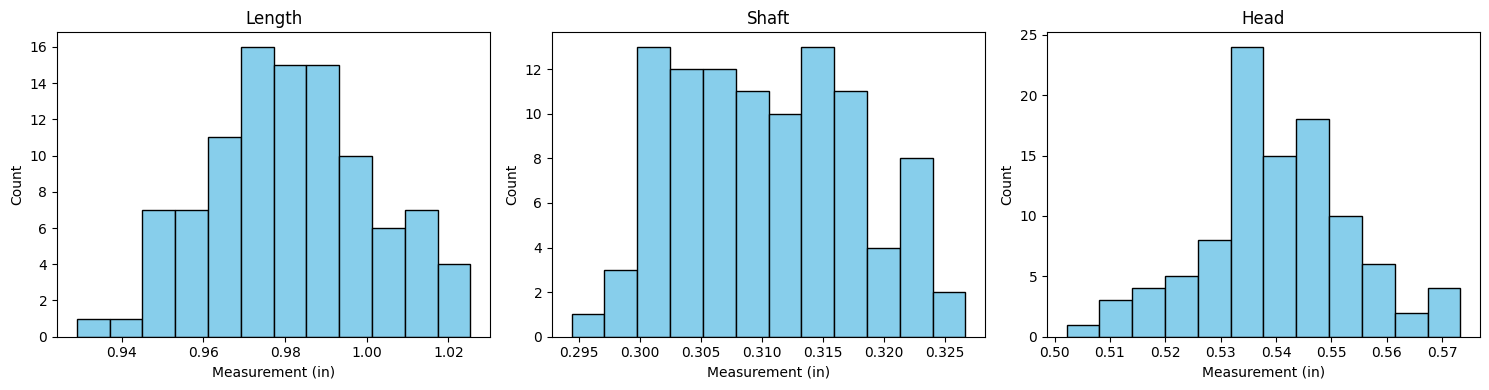

In [23]:

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for ax, dim, label in zip(axs, [lengths, shafts, heads], ['Length', 'Shaft', 'Head']):
    ax.hist(dim, bins=12, color='skyblue', edgecolor='k')
    ax.set_title(label)
    ax.set_xlabel('Measurement (in)')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()




> **Challenge:**
> - How do the shapes and spreads of the histograms relate to the computed uncertainty of each measurement?

